In [266]:
import requests
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import json
import sys
import simplejson
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import urllib

In [223]:
from requests.exceptions import HTTPError

for url in ['https://www.bezrealitky.cz/api/record/markers?offerType=prodej&estateType=byt&locationInput=Praha']:
    try:
        response = requests.get(url)
        response.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')
    except Exception as err:
        print(f'Other error occurred: {err}')
    else:
        print('Success!')

Success!


In [224]:
response.json()
#outputs api response as json

[{'id': '562843',
  'uri': '562843-nabidka-prodej-bytu',
  'keyAdvertType': 'estate_offer',
  'type': '',
  'timeOrder': {'date': '2019-05-31 21:20:43.000000',
   'timezone_type': 3,
   'timezone': 'Europe/Prague'},
  'orderPriority': 0,
  'advertEstateOffer': [{'gps': '{"lat":50.678639399999987,"lng":14.042853100000002}',
    'price': 900000,
    'currency': 'CZK',
    'keyOfferType': 'prodej',
    'keyEstateType': 'byt',
    'keyDisposition': '1-1',
    'surface': 40,
    'id': '562843'}]},
 {'id': '562838',
  'uri': '562838-nabidka-prodej-bytu-podrouzkova-ostrava',
  'keyAdvertType': 'estate_offer',
  'type': '',
  'timeOrder': {'date': '2019-05-31 20:07:46.000000',
   'timezone_type': 3,
   'timezone': 'Europe/Prague'},
  'orderPriority': 1,
  'advertEstateOffer': [{'gps': '{"lat":49.844851800000001,"lng":18.173335800000018}',
    'price': 2230000,
    'currency': 'CZK',
    'keyOfferType': 'prodej',
    'keyEstateType': 'byt',
    'keyDisposition': '3-1',
    'surface': 67,
    'i

In [225]:
urls = response.json()

In [226]:
wjdata = json.dumps(response.json(), indent=4, separators=(", ", " = "))


In [227]:
print(wjdata)
#nicer form of json


[
    {
        "id" = "562843", 
        "uri" = "562843-nabidka-prodej-bytu", 
        "keyAdvertType" = "estate_offer", 
        "type" = "", 
        "timeOrder" = {
            "date" = "2019-05-31 21:20:43.000000", 
            "timezone_type" = 3, 
            "timezone" = "Europe/Prague"
        }, 
        "orderPriority" = 0, 
        "advertEstateOffer" = [
            {
                "gps" = "{\"lat\":50.678639399999987,\"lng\":14.042853100000002}", 
                "price" = 900000, 
                "currency" = "CZK", 
                "keyOfferType" = "prodej", 
                "keyEstateType" = "byt", 
                "keyDisposition" = "1-1", 
                "surface" = 40, 
                "id" = "562843"
            }
        ]
    }, 
    {
        "id" = "562838", 
        "uri" = "562838-nabidka-prodej-bytu-podrouzkova-ostrava", 
        "keyAdvertType" = "estate_offer", 
        "type" = "", 
        "timeOrder" = {
            "date" = "2019-05-31 20:07:46.000

In [228]:
f = open("api-output.json","w")
f.write(wjdata)
f.close()
#writes this data in the api-output file

In [229]:
uriDeveloper = []
for element in urls:
    if element['type'] == 'iDeveloper':
        uriDeveloper.append(element['uri'])

#sources all uri when an estate is "iDeveloper" type

In [230]:
developerLinks = list(uriDeveloper)
#this is a nicer list

In [231]:
uriPrivate = []
for element in urls:
    if element['type'] == '':
        uriPrivate.append(element['uri'])
        
#sources all uri when an estate is null type - private offerings

In [232]:
privateLinks = list(map('https://www.bezrealitky.cz/nemovitosti-byty-domy/'.__add__,uriPrivate))
#adds a url string before each row of the list

In [279]:
test = privateLinks[:100]
#take a small sample from privateLinks because of original sample being too large to process fast

In [285]:
class bezrea_Web:
    '''
    class with functions extracting values of interest for each offer
    '''
    def __init__(self,link,allowLog=True):
        self.allowLog = allowLog
        self.link = link
        r = requests.get(link)
        r.encoding='UTF-8'
        self.soup = BeautifulSoup(r.text,'lxml')
        if self.allowLog:
            print('Success!')


    def parsePrice(self):
        '''
        extraction of price of an offer as an integer
        '''
        prices = []
        pdTbl = pd.read_html(self,attrs= {"class":"table"})
        price = int(''.join(re.findall(r'\d+',pdTbl[0][1][4])))
        return price
        
    def parseSize(self):
        '''
        extraction of size of an offer as an integer
        '''
        pdTbl = pd.read_html(self,attrs= {"class":"table"})
        size = int(re.findall(r'\d+',pdTbl[0][1][3])[0])
        return size
    
    def parseType(self):
        '''
        extract types of offers
        '''
        pdTbl = pd.read_html(self,attrs= {"class":"table"})
        atype = pdTbl[0][1][2]
        return atype
    
    def parseRegion(self):
        '''
        extract region of offer
        '''
        web = urllib.request.urlopen(self)
        soup = BeautifulSoup(web,'lxml')
        region = soup.findAll("span", attrs = {"itemprop":"title"})[3].text.strip()
        return region
    
    def parseDistrict(self):
        '''
        extract district of offer
        '''
        web = urllib.request.urlopen(self)
        soup = BeautifulSoup(web,'lxml')
        district = soup.findAll("span", attrs = {"itemprop":"title"})[4].text.strip()
        return district

In [286]:
#list of districts of offers
districts = []
for i in test:
    districts.append(bezrea_Web.parseDistrict(i))

In [278]:
#list of regions of offers
regions = []
for i in test:
    regions.append(bezrea_Web.parseRegion(i))

In [261]:
#list of types of offers
types = []
for i in test:
    types.append(bezrea_Web.parseType(i))

In [294]:
#creation on numpy array of prices for all offers
prices = []
for i in test:
    prices.append(bezrea_Web.parsePrice(i))
numPrices = np.array(prices)

In [194]:
#creation on numpy array of sizes for all offers
sizes = []
for i in test:
    sizes.append(bezrea_Web.parseSize(i))
numSizes = np.array(sizes)

SIZE STATISTICS

In [203]:
np.average(numSizes)

64.87

In [206]:
np.median(numSizes)

65.0

In [208]:
np.max(numSizes)

129

In [209]:
np.min(numSizes)

20

In [204]:
np.average(numPrices)

4013925.29

In [210]:
np.median(numPrices)

3800000.0

In [211]:
np.max(numPrices)

14620000

In [212]:
np.min(numPrices)

100000

In [217]:
np.std(numPrices)

2336193.1181705473

In [ ]:
PRICE PER METER SQUARED STATISTICS

In [199]:
pricePerMtr = np.divide(numPrices,numSizes)

In [205]:
np.average(pricePerMtr)

63627.930980894926

In [213]:
np.median(pricePerMtr)

64128.1512605042

In [214]:
np.max(pricePerMtr)

151600.0

In [215]:
np.min(pricePerMtr)

1166.6666666666667

In [216]:
np.std(pricePerMtr)

31136.8485890253

VISUALIZATIONS

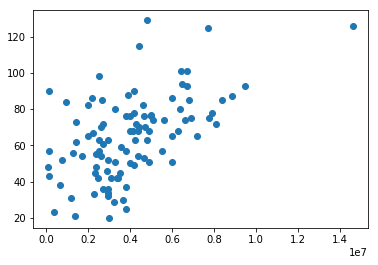

In [220]:
plt.scatter(numPrices,numSizes)

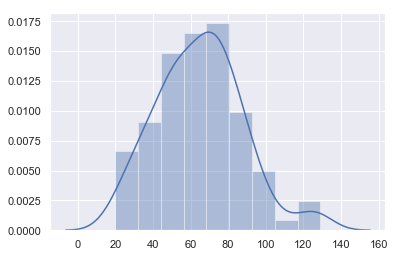

In [240]:
sns.distplot(numSizes)
plt.show()

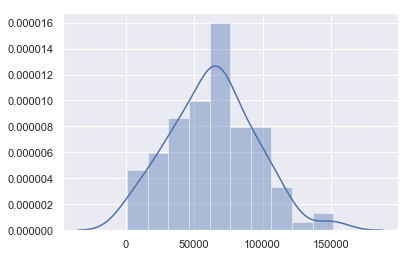

In [243]:
sns.distplot(pricePerMtr)

C:\Users\Matt\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


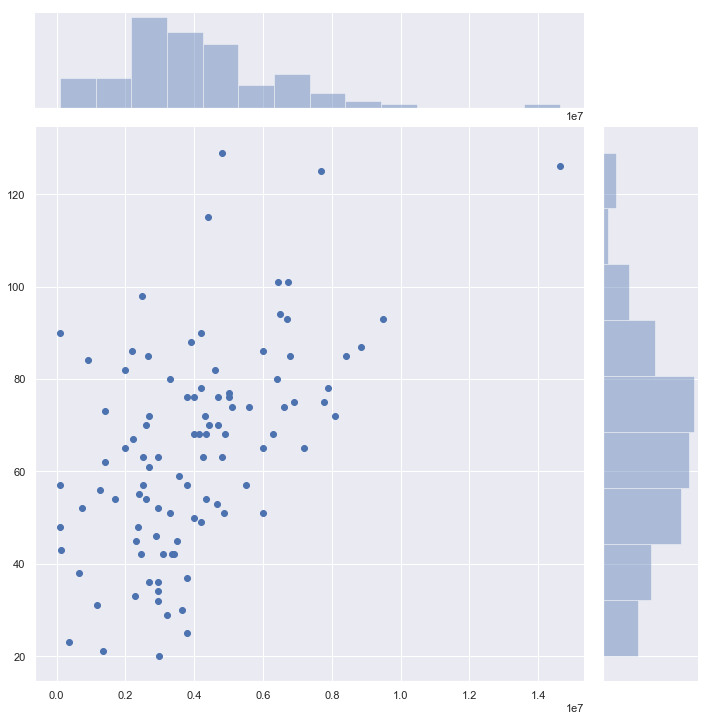

In [244]:
sns.jointplot(numPrices,numSizes,size=(10))
plt.show()

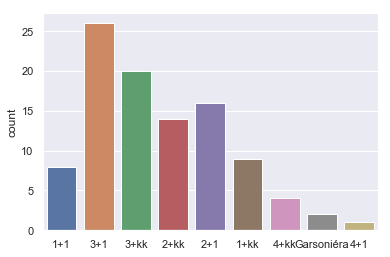

In [263]:
#distribution of offer types
sns.countplot(types)

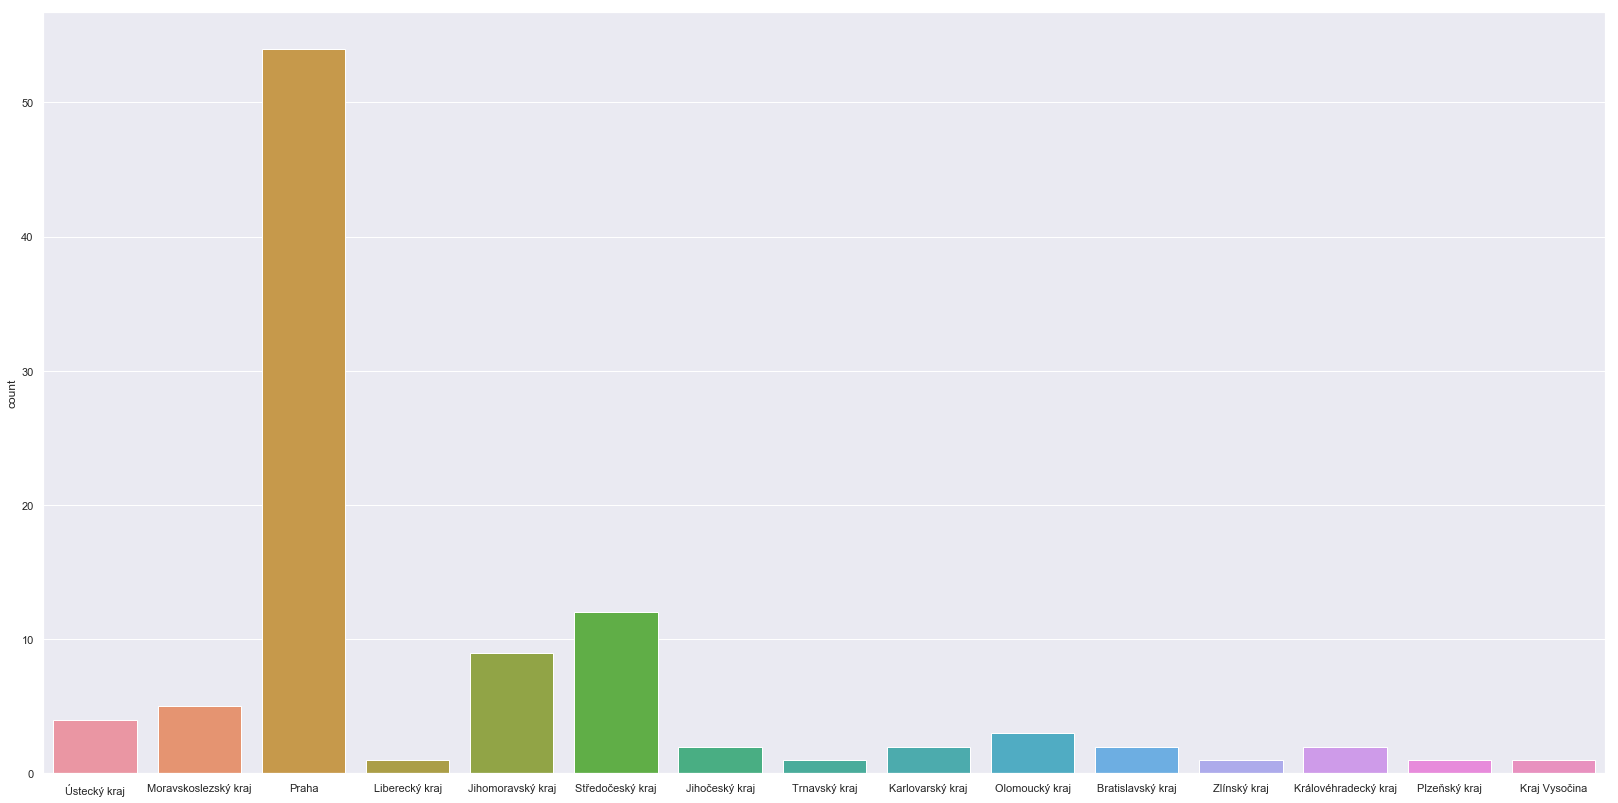

In [284]:
#distribution of offer regions
plt.figure(figsize=(28,14)) 
sns.countplot(regions)
plt.show()

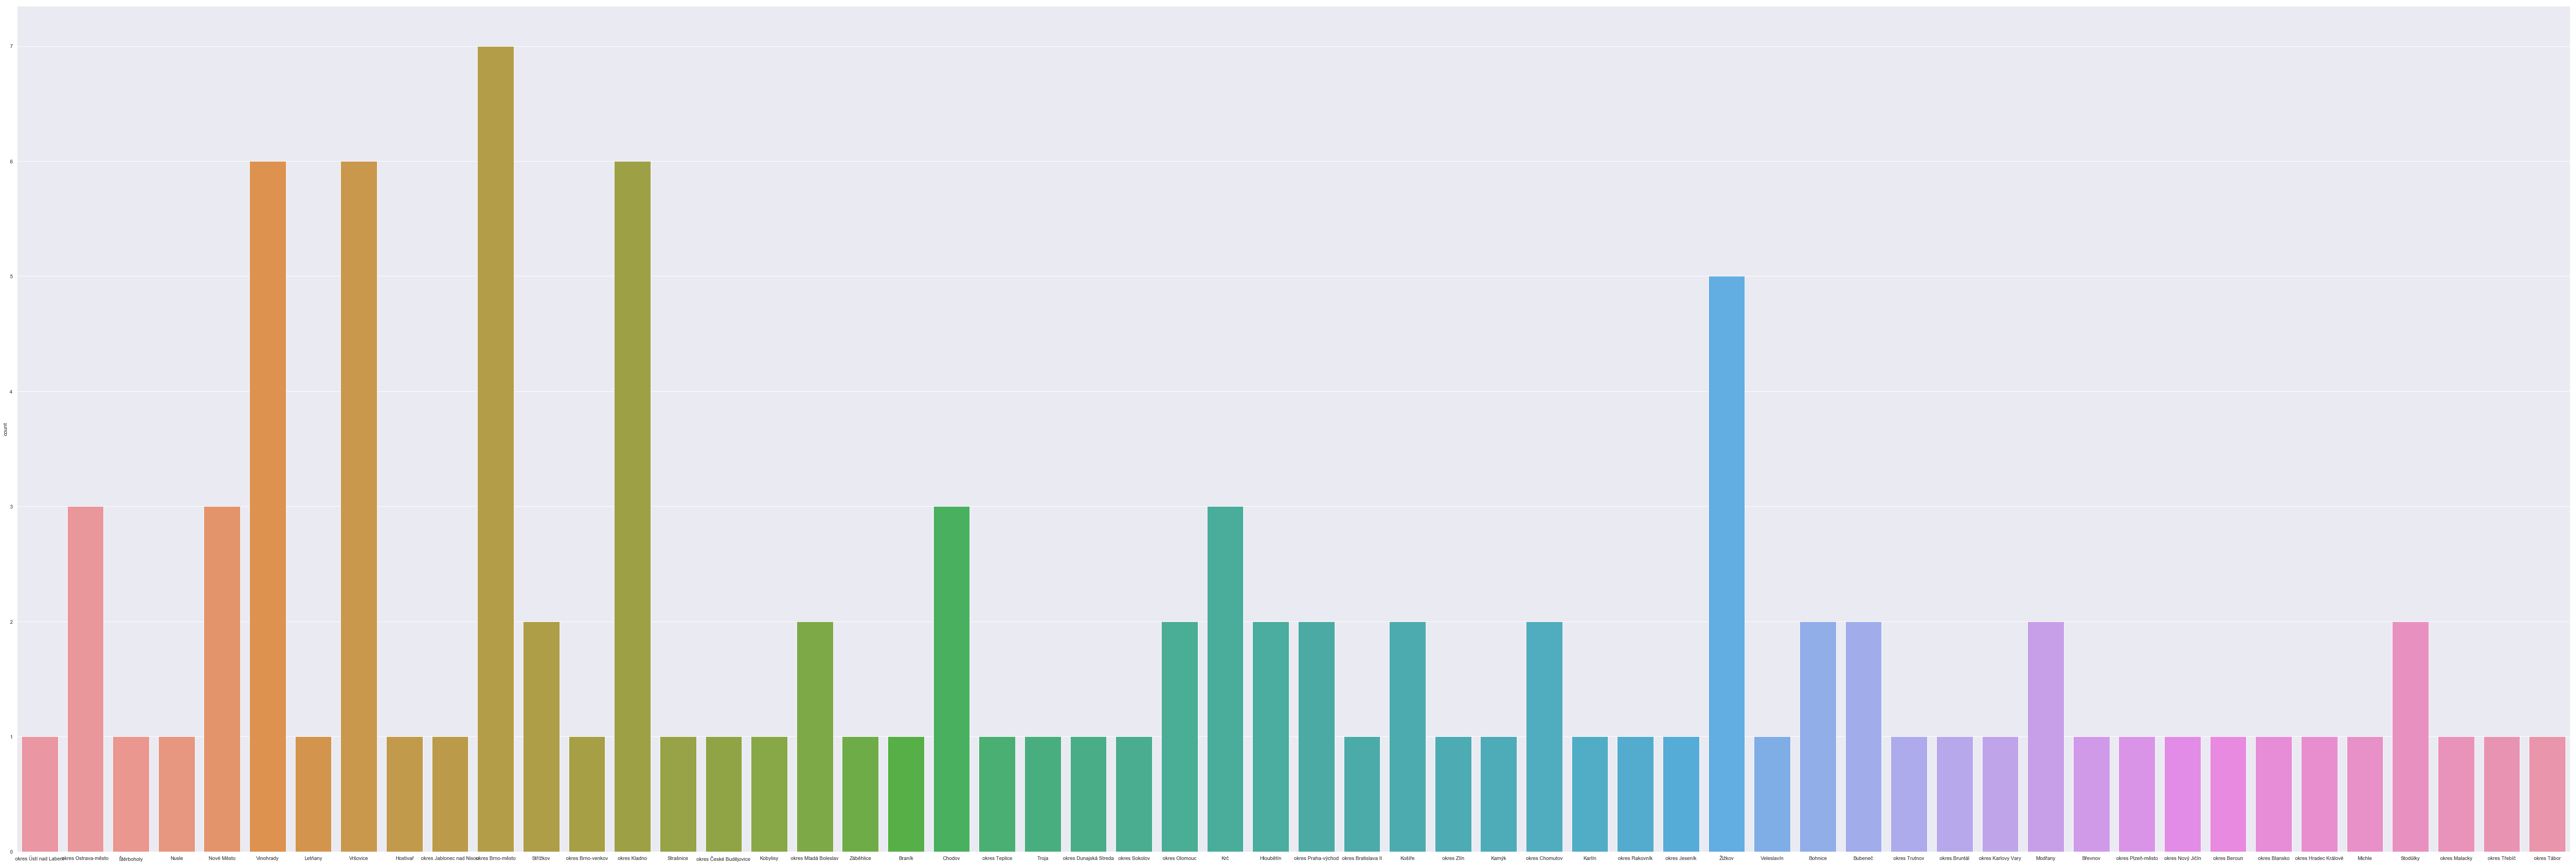

In [290]:
#distribution of offer regions
plt.figure(figsize=(100,34)) 
sns.countplot(districts)
plt.show()
#unfortunatelly, the image cannot be well seen in Jupyter Notebook. We reccomend opening the image in a new tab

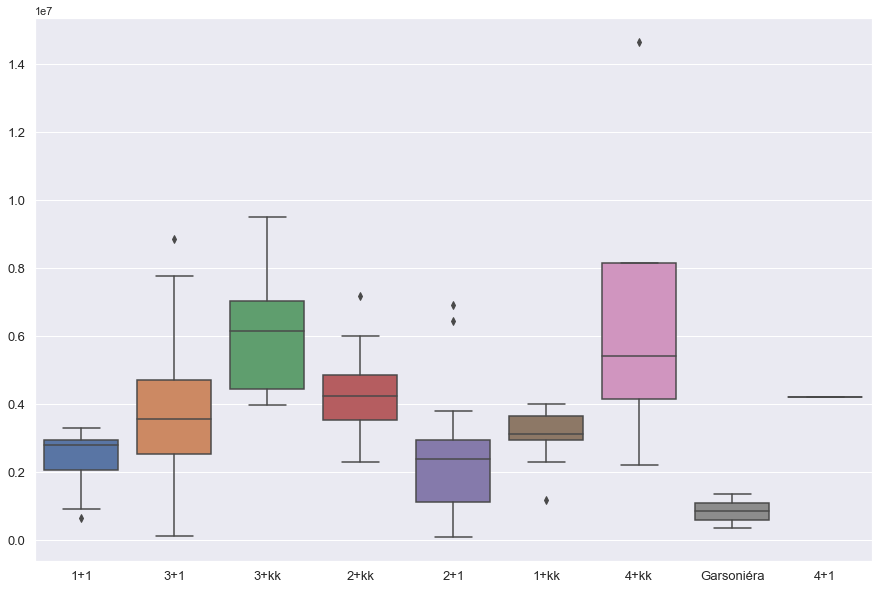

In [296]:
#boxplot for prices by types of offers
plt.figure(figsize=(15,10))
ax = sns.boxplot(types, prices)
ax.tick_params(labelsize=13)
plt.show()

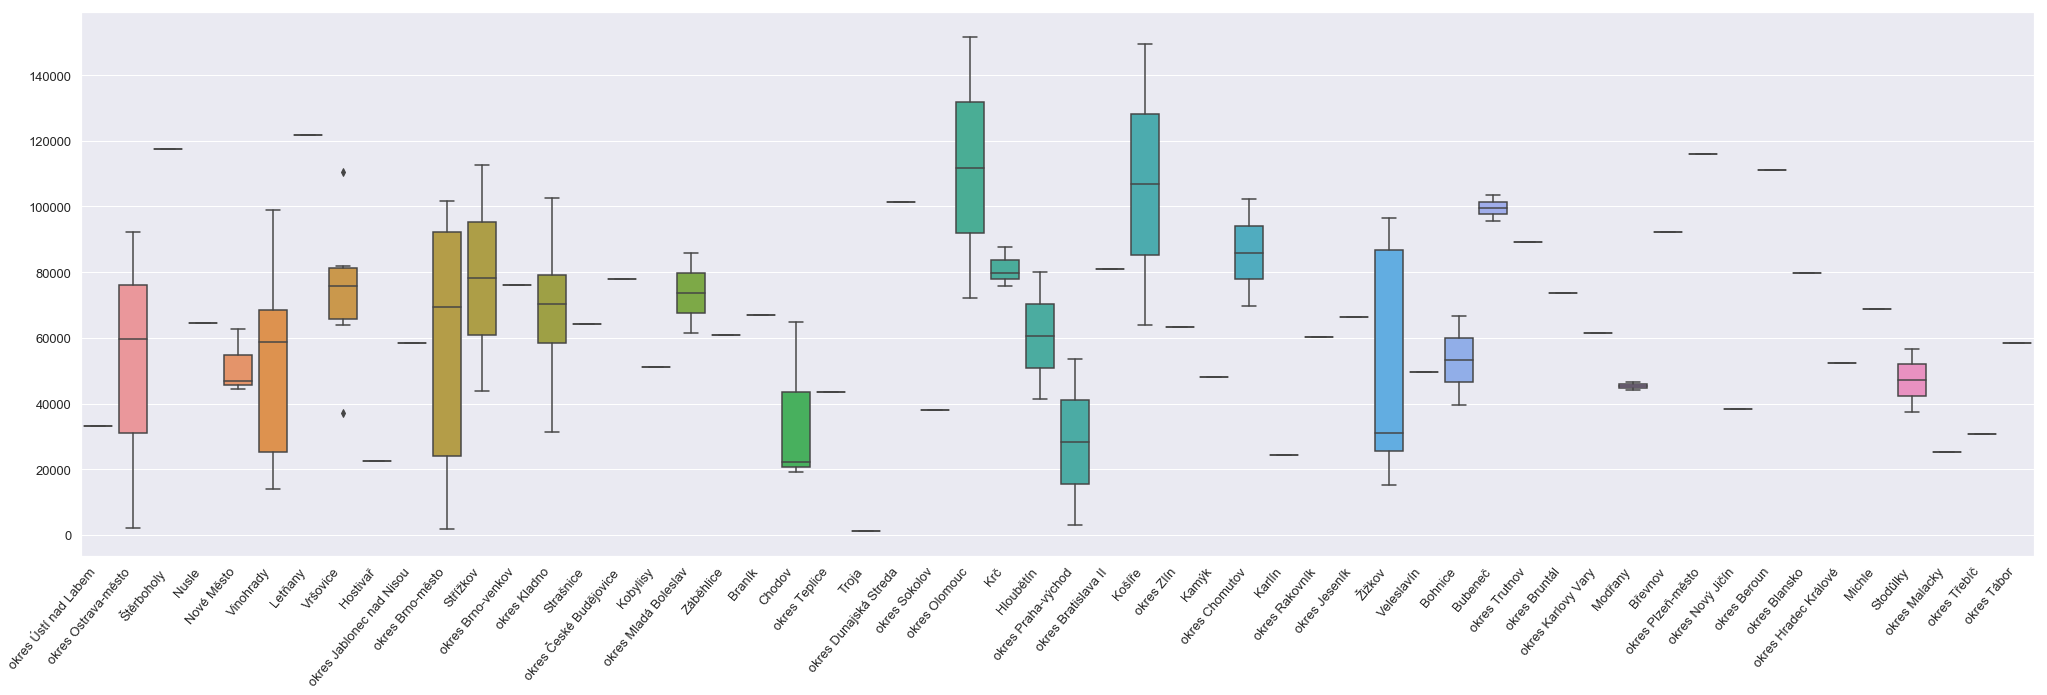

In [299]:
#boxplot of prices per meter squared by districts
#again, we recommend opening the image in a new tab
plt.figure(figsize=(35,10))
ax = sns.boxplot(districts, pricePerMtr)
ax.set_xticklabels(ax.get_xticklabels(),rotation=50,ha="right")
ax.tick_params(labelsize=13)
plt.show()